# Prepare

## Package

In [1]:
import re
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from collections import OrderedDict

2023-03-10 17:32:22.427079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 17:32:25.680406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 17:32:25.680432: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 17:32:30.307317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Define F1 score, Precision, Recall

In [2]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
def step_decay(epoch):
    start = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = start * (drop ** np.floor((epoch)/epochs_drop))
    return lr

## Prepare Dataset

In [4]:
struct_log = '../data/HDFS/HDFS_100k.log_structured.csv'

data = pd.read_csv(struct_log, engine='c',na_filter=False,memory_map=True)
label = pd.read_csv('../data/HDFS/anomaly_label.csv', engine='c',na_filter=False,memory_map=True)

# BlockId, EventSequence로 구성된 데이터 프레임으로 전처리
data_dict = OrderedDict()
for idx, row in data.iterrows():    
    blkId_list = re.findall(r'(blk_-?\d+)',row['Content'])
    blkId_set = set(blkId_list)
    for blk_Id in blkId_set:
        if not blk_Id in data_dict:
            data_dict[blk_Id] = []
        data_dict[blk_Id].append(row['EventId'])
    
data_df = pd.DataFrame(list(data_dict.items()),columns=['BlockId','EventSequence'])

label_data = label.set_index('BlockId')
label_dict = label_data['Label'].to_dict()
data_df['Label'] = data_df['BlockId'].apply(lambda x: 1 if label_dict[x] == 'Anomaly' else 0)

sentiment = data_df['Label']
sentence = data_df.drop(['Label'],axis=1)

In [5]:
data[:5]

,LineId,Date,Time,Pid,Level,Component,Content,EventId,EventTemplate
0,1,81109,203518,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
1,2,81109,203518,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,E22,BLOCK* NameSystem.allocateBlock:<*>
2,3,81109,203519,143,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
3,4,81109,203519,145,INFO,dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,E5,Receiving block <*> src: /<*> dest: /<*>
4,5,81109,203519,145,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_-1608999687919...,E11,PacketResponder <*> for block <*> terminating


In [6]:
sentiment[:5]

0    0
1    0
2    1
3    0
4    0
Name: Label, dtype: int64

In [7]:
sentence[:5]

,BlockId,EventSequence
0,blk_-1608999687919862906,"[E5, E22, E5, E5, E11, E11, E9, E9, E11, E9, E..."
1,blk_7503483334202473044,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."
2,blk_-3544583377289625738,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
3,blk_-9073992586687739851,"[E5, E22, E5, E5, E11, E9, E11, E9, E11, E9, E..."
4,blk_7854771516489510256,"[E5, E5, E22, E5, E11, E9, E11, E9, E11, E9, E..."


/home/won/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Label', ylabel='count'>

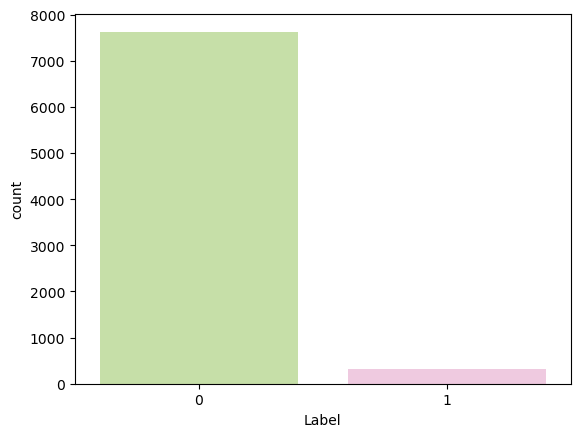

In [8]:
import seaborn as sns
sns.countplot(data_df['Label'],palette='PiYG_r')

<AxesSubplot:xlabel='EventId', ylabel='count'>

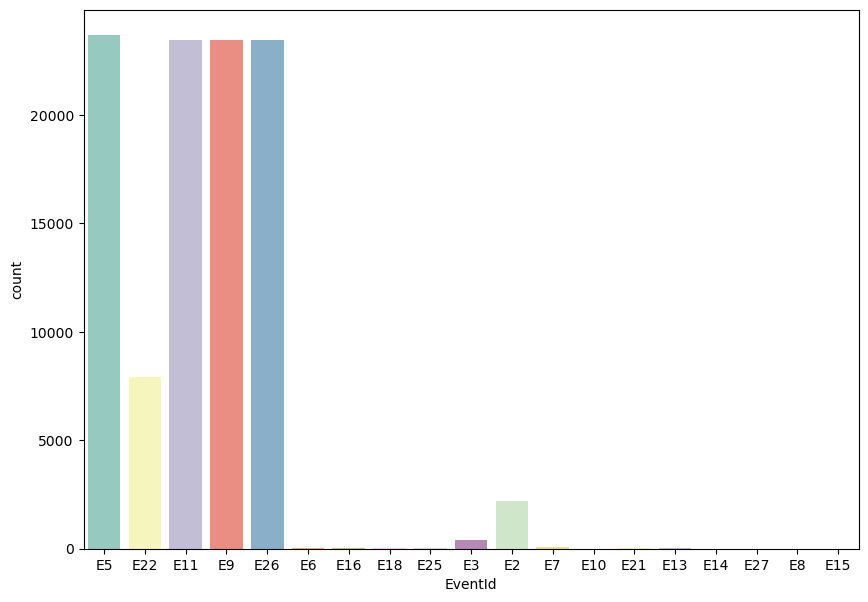

In [9]:
f, (ax1) = plt.subplots(1, figsize=(10,7))
sns.countplot(data=data, x='EventId',palette='Set3')

## feature extraction

In [10]:
max_len = 500
word_features = max([len(x) for x in sentence['EventSequence'].values])

# 쉼표로 끊는 규칙의 토크나이저
tokenizer = Tokenizer(num_words=word_features,split=',')

#각 문장에 토크나이저 적용
tokenizer.fit_on_texts(sentence['EventSequence'])
word_index = tokenizer.word_index
print(word_index)

# 각 문장을 문맥을 파악하게끔 시퀀스화
X = tokenizer.texts_to_sequences(sentence['EventSequence'])
X = pad_sequences(X)
print(X)

{'e5': 1, 'e26': 2, 'e11': 3, 'e9': 4, 'e22': 5, 'e2': 6, 'e3': 7, 'e7': 8, 'e6': 9, 'e16': 10, 'e18': 11, 'e25': 12, 'e13': 13, 'e21': 14, 'e14': 15, 'e10': 16, 'e15': 17, 'e27': 18, 'e8': 19}
[[1 5 1 ... 7 7 7]
 [0 0 0 ... 7 6 6]
 [0 0 0 ... 7 7 7]
 ...
 [0 0 0 ... 3 4 2]
 [0 0 0 ... 3 4 2]
 [0 0 0 ... 2 3 4]]


## Dataset Split

In [11]:
X_train, X_x, y_train, y_y = train_test_split(
    X, sentiment, test_size=0.2, random_state=7, stratify=sentiment
)

X_test, X_valid, y_test, y_valid = train_test_split(
    X_x, y_y, test_size=0.5, random_state=7, stratify=y_y
)

print('Train set count:',len(X_train))
print('Test set count:',len(X_test))
print('Valid set count:',len(X_valid))

Train set count: 6352
Test set count: 794
Valid set count: 794


# 1. Simple Model


In [12]:
model = Sequential([
    Embedding(max_len, 32, input_length=word_features),
    Flatten(),
    Dense(1, activation='sigmoid') # binary logistic regression 수행
])

model.summary()

2023-03-10 17:32:39.100219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 17:32:39.100525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 17:32:39.100628: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-10 17:32:39.100697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-10 17:32:39.100754: W tensorflow/c

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 249, 32)           16000     
                                                                 
 flatten (Flatten)           (None, 7968)              0         
                                                                 
 dense (Dense)               (None, 1)                 7969      
                                                                 
Total params: 23,969
Trainable params: 23,969
Non-trainable params: 0
_________________________________________________________________


## Train model
### loss:0.096, accuracy:0.982, f1_score:0.422, precision:0.500, recall:0.384

In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])
early_stopping = EarlyStopping(monitor='val_loss',patience=10, mode='min')
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler],
                    validation_data=(X_valid,y_valid))


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
199/199 [==============================] - 2s 1ms/step - loss: 0.1392 - acc: 0.9651 - f1_m: 0.2768 - precision_m: 0.3382 - recall_m: 0.2595 - val_loss: 0.1068 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
199/199 [==============================] - 0s 902us/step - loss: 0.1142 - acc: 0.9780 - f1_m: 0.3506 - precision_m: 0.4196 - recall_m: 0.3250 - val_loss: 0.1043 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
199/199 [==============================] - 0s 843us/step - loss: 0.1179 - acc: 0.9776 - f1_m: 0.3333 - precision_m: 0.3975 - recall_m: 0.3065 - val_loss: 0.1113 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100


## Visulization

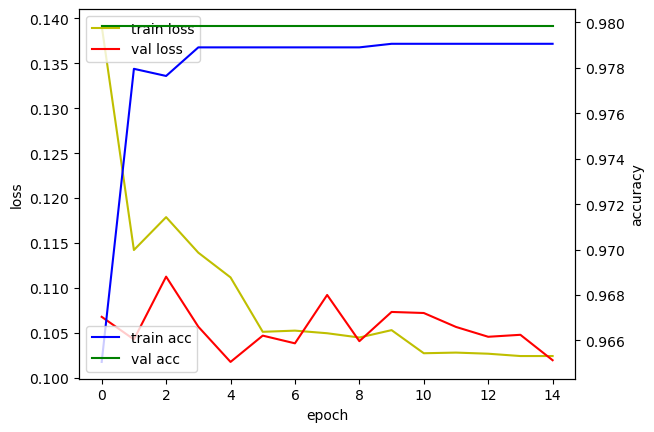

In [14]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'],'y',label='train loss')
loss_ax.plot(history.history['val_loss'],'r',label='val loss')

acc_ax.plot(history.history['acc'],'b', label = 'train acc')
acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
    
plt.show()

## Test data prediction

In [15]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("loss:%.3f, accuracy:%.3f, f1_score:%.3f, precision:%.3f, recall:%.3f"%(loss,accuracy,f1_score,precision,recall))

loss:0.084, accuracy:0.984, f1_score:0.492, precision:0.520, recall:0.480


# 2. RNN

In [16]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(word_features,32),
    # 펼치기 전에 바로 RNN 레이어 사용, 은닉 노드의 크기 32로 했으나 다른 값도 상관 없음
    SimpleRNN(32), 
    
    # 은닉 노드 하나 추가로 성능 향상
    Dense(32,activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          7968      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________


## Train model
### 

In [17]:
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
early_stopping = EarlyStopping(monitor='val_loss',patience=10, mode='min')
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler],
                    validation_data=(X_valid,y_valid))


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
199/199 [==============================] - 4s 16ms/step - loss: 0.1417 - acc: 0.9595 - f1_m: 0.2877 - precision_m: 0.3446 - recall_m: 0.2714 - val_loss: 0.1483 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
199/199 [==============================] - 7s 34ms/step - loss: 0.1130 - acc: 0.9773 - f1_m: 0.3271 - precision_m: 0.3920 - recall_m: 0.2990 - val_loss: 0.1027 - val_acc: 0.9786 - val_f1_m: 0.3907 - val_precision_m: 0.4800 - val_recall_m: 0.3533 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
199/199 [==============================] - 3s 15ms/step - loss: 0.1093 - acc: 0.9775 - f1_m: 0.3443 - precision_m: 0.4146 - recall_m: 0.3151 - val_loss: 0.1020 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100



## Visualization

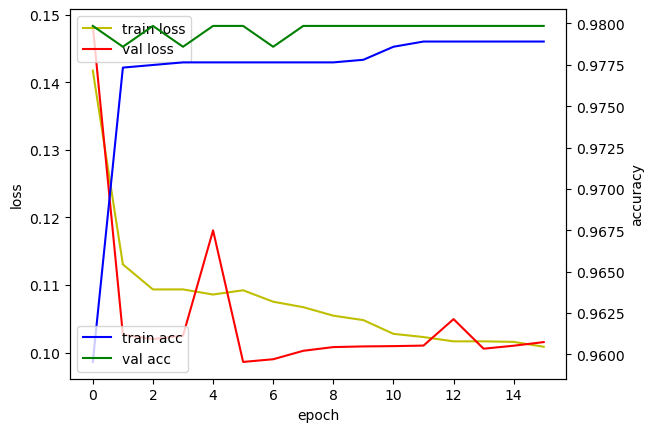

In [18]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'],'y',label='train loss')
loss_ax.plot(history.history['val_loss'],'r',label='val loss')

acc_ax.plot(history.history['acc'],'b', label = 'train acc')
acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
    
plt.show()

## Test data prediction

In [19]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("loss:%.3f, accuracy:%.3f, f1_score:%.3f, precision:%.3f, recall:%.3f"%(loss,accuracy,f1_score,precision,recall))

loss:0.083, accuracy:0.984, f1_score:0.492, precision:0.520, recall:0.480


# 3. LSTM

In [20]:
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential([
    Embedding(word_features,64),
    Bidirectional(LSTM(64)),
    Dense(64,activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          15936     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 90,305
Trainable params: 90,305
Non-trainable params: 0
_________________________________________________________________


## Train model

In [21]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
early_stopping = EarlyStopping(monitor='val_loss',patience=10, mode='min')
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[early_stopping, lr_scheduler],
                    validation_data=(X_valid,y_valid))


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
199/199 [==============================] - 13s 59ms/step - loss: 0.1265 - acc: 0.9706 - f1_m: 0.3070 - precision_m: 0.3695 - recall_m: 0.2831 - val_loss: 0.1093 - val_acc: 0.9786 - val_f1_m: 0.4107 - val_precision_m: 0.4800 - val_recall_m: 0.3800 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
199/199 [==============================] - 12s 58ms/step - loss: 0.1078 - acc: 0.9783 - f1_m: 0.3391 - precision_m: 0.4196 - recall_m: 0.3020 - val_loss: 0.1048 - val_acc: 0.9748 - val_f1_m: 0.2987 - val_precision_m: 0.3600 - val_recall_m: 0.2733 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
199/199 [==============================] - 8s 38ms/step - loss: 0.1051 - acc: 0.9784 - f1_m: 0.3624 - precision_m: 0.4372 - recall_m: 0.3270 - val_loss: 0.1064 - val_acc: 0.9798 - val_f1_m: 0.4307 - val_precision_m: 0.5200 - val_recall_m: 0.3933 - lr: 0.0100

## Visualization

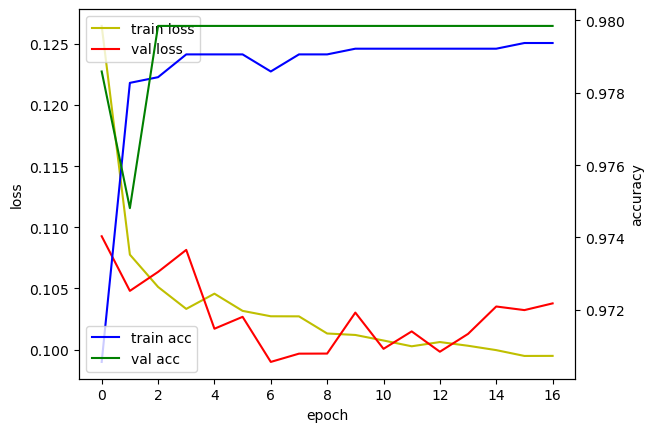

In [22]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'],'y',label='train loss')
loss_ax.plot(history.history['val_loss'],'r',label='val loss')

acc_ax.plot(history.history['acc'],'b', label = 'train acc')
acc_ax.plot(history.history['val_acc'],'g',label = 'val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
    
plt.show()

## Test data prediction

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("loss:%.3f, accuracy:%.3f, f1_score:%.3f, precision:%.3f, recall:%.3f"%(loss,accuracy,f1_score,precision,recall))

loss:0.084, accuracy:0.984, f1_score:0.492, precision:0.520, recall:0.480


## 다양한 로그 입력시 패턴 저장

In [24]:
new_struct_log = '../data/HDFS/HDFS_2k.log_structured_rev.csv'

new_data = pd.read_csv(new_struct_log, engine='c',na_filter=False,memory_map=True)

# 새로운 로그의 EventID가 기존 로그의 EventID와 호환 및 중복되지 않도록 변환
# 기존 로그에 없던 E3, E4, E8 이벤트는 E30, E31, E32로 추가함
new_data['EventId']=new_data['EventId'].replace(['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14'],['E3','E18','E30','E31','E25','E26','E22','E32','E21','E11','E9','E6','E5','E2'])

In [25]:
# BlockId, EventSequence로 구성된 데이터 프레임으로 전처리
new_data_dict = OrderedDict()
for idx, row in new_data.iterrows():    
    blkId_list = re.findall(r'(blk_-?\d+)',row['Content'])
    blkId_set = set(blkId_list)
    for blk_Id in blkId_set:
        if not blk_Id in new_data_dict:
            new_data_dict[blk_Id] = []
        new_data_dict[blk_Id].append(row['EventId'])
    
new_data_df = pd.DataFrame(list(new_data_dict.items()),columns=['BlockId','EventSequence'])
print(new_data_df[:5])

                    BlockId EventSequence
0     blk_38865049064139660         [E11]
1  blk_-6952295868487656571         [E11]
2   blk_7128370237687728475         [E26]
3   blk_8229193803249955061         [E11]
4  blk_-6670958622368987959         [E11]


In [26]:
new_data_df

new = tokenizer.texts_to_sequences(new_data_df['EventSequence'])
new = pad_sequences(new)
predictions = model.predict(new)
predictions = predictions.astype(float)

result = []
for i in range(len(predictions)):
    if predictions[i] < 0.5: # 예측값이 0.5 이하이면 부정
        result.append(['neg',new_data_df['EventSequence'][i]])
        print("%.2f%% 확률로 부정 리뷰입니다."%((1-predictions[i])*100))
    else:
        result.append(['pos',new_data_df['EventSequence'][i]])
        print("%.2f%% 확률로 긍정 리뷰입니다."%(predictions[i]*100))

        
print('sentiment analysis logs:',result[:5])


69/69 [==============================] - 0s 537us/step
93.14% 확률로 부정 리뷰입니다.
93.14% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
93.14% 확률로 부정 리뷰입니다.
93.14% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
93.14% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
100.00% 확률로 긍정 리뷰입니다.
93.14% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
100.00% 확률로 긍정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
100.00% 확률로 긍정 리뷰입니다.
93.53% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
71.85% 확률로 부정 리뷰입니다.
93.55% 확률로 부정 리뷰입니다.
92.15% 확률로 부정 리뷰입니

In [27]:
print(new_data_df['EventSequence'][1])

['E11']


## 추가 입력시 패턴 저장


In [28]:
new_sentence = [['E3'],
                ['E1', 'E3', 'E4', 'E9', 'E12', 'E15', 'E21'], # 임의 생성
                ['E2','E2','E4','E5','E6'],
                ['E2','E2','E4','E5','E6','E11','E9','E11','E9','E11'],
                ['E5','E5','E22','E5','E11','E9','E11','E9','E11','E9','E26','E26','E26','E3','E2']]

new = tokenizer.texts_to_sequences((new_sentence))
new = pad_sequences(new)
predictions = model.predict(new)
predictions = predictions.astype(float)

result = []
for i in range(len(predictions)):
    if predictions[i] < 0.5: # 예측값이 0.5 이하이면 부정
        result.append(['neg',new_sentence[i]])
        print("%.2f%% 확률로 부정 리뷰입니다."%((1-predictions[i])*100))
    else:
        result.append(['pos',new_sentence[i]])
        print("%.2f%% 확률로 긍정 리뷰입니다."%(predictions[i]*100))

        
print('sentiment analysis logs:',result)


1/1 [==============================] - 0s 287ms/step
99.96% 확률로 긍정 리뷰입니다.
96.89% 확률로 긍정 리뷰입니다.
100.00% 확률로 긍정 리뷰입니다.
90.66% 확률로 부정 리뷰입니다.
99.47% 확률로 부정 리뷰입니다.
sentiment analysis logs: [['pos', ['E3']], ['pos', ['E1', 'E3', 'E4', 'E9', 'E12', 'E15', 'E21']], ['pos', ['E2', 'E2', 'E4', 'E5', 'E6']], ['neg', ['E2', 'E2', 'E4', 'E5', 'E6', 'E11', 'E9', 'E11', 'E9', 'E11']], ['neg', ['E5', 'E5', 'E22', 'E5', 'E11', 'E9', 'E11', 'E9', 'E11', 'E9', 'E26', 'E26', 'E26', 'E3', 'E2']]]
